# **Stock Price Prediction**

 Develop a machine learning model that accurately predicts future stock prices based on historical data. This involves leveraging techniques from time series analysis and deep learning to create a robust predictive model that can assist investors and financial analysts in making informed decisions.

 **Dataset Link -** https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

**Install Kaggle library**

In [2]:
!pip install kaggle

**Upload Kaggle API token**

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


**Download the dataset**

In [4]:
!kaggle datasets download -d tsaustin/us-historical-stock-prices-with-earnings-data

Dataset URL: https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data
License(s): unknown
100% 463M/463M [00:26<00:00, 17.4MB/s]
100% 463M/463M [00:26<00:00, 18.1MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("us-historical-stock-prices-with-earnings-data.zip", "r") as zip_ref:
    zip_ref.extractall("data")

**Import Libraries and Load Data**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [8]:
data = pd.read_csv("/content/data/stocks_latest/stock_prices_latest.csv")
data

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.800,51.96,50.7500,51.83,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.850,69.84,67.8500,67.87,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.410,55.00,53.1700,54.32,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.010,36.03,34.5600,35.03,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.610,42.29,41.5100,42.25,38.6773,74640000,1.0
...,...,...,...,...,...,...,...,...,...
24395011,HA,2021-06-03,25.510,26.19,24.9389,25.92,25.9200,1287065,1.0
24395012,HA,2021-06-04,26.160,26.69,25.9400,26.04,26.0400,993843,1.0
24395013,HA,2021-06-10,29.790,29.97,26.1100,26.20,26.2000,2402349,1.0
24395014,HA,2021-06-07,26.210,26.35,25.7400,26.00,26.0000,514048,1.0


In [15]:
data.columns = map(str.lower, data.columns)

**Sample time series data for stock prices**

In [16]:
np.random.seed(0)
dates = pd.date_range('1999-01-01', periods=500, freq='D')
prices = np.cumsum(np.random.randn(500)) + 100
data = pd.DataFrame({'Date': dates, 'Close': prices})
data.set_index('Date', inplace=True)

**Plot the data**

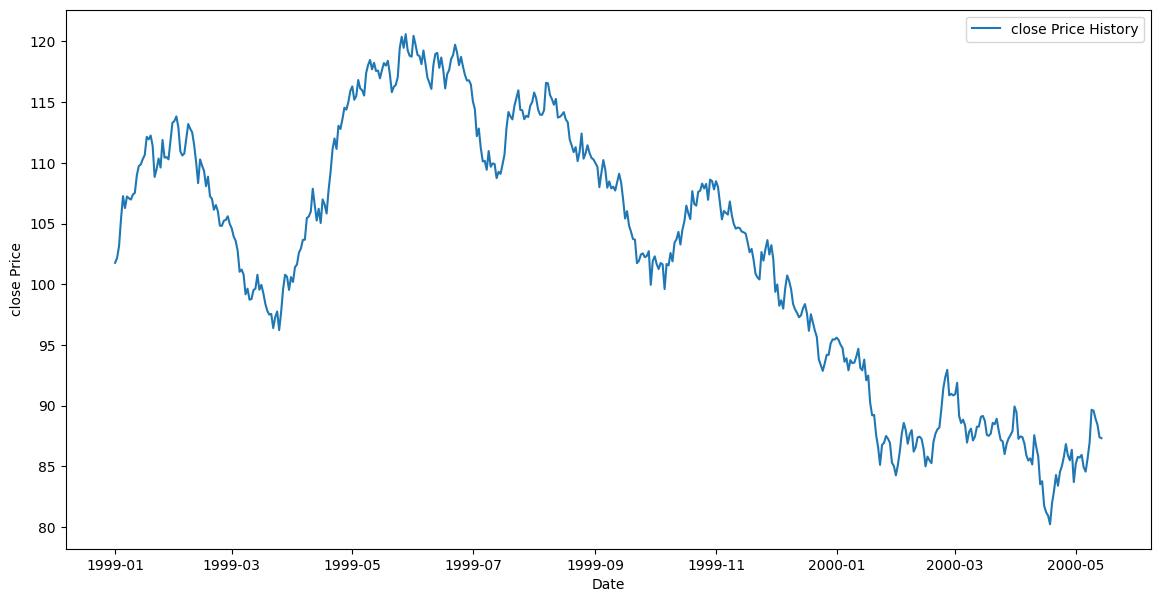

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='close Price History')
plt.xlabel('Date')
plt.ylabel('close Price')
plt.legend()
plt.show()

**Prepare the data**

In [20]:
data = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

**Create the training and testing data**

In [22]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [23]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [24]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

**Reshape input**

In [25]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**Create the LSTM model**

In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train the model**

In [28]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

339/339 [==============================] - 15s 32ms/step - loss: 0.0099


**Predictions**

In [29]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 21ms/step


**Transform back to original form**

In [30]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

**Plot the results**

In [31]:
look_back = time_step
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

In [32]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(data) - 1, :] = test_predict

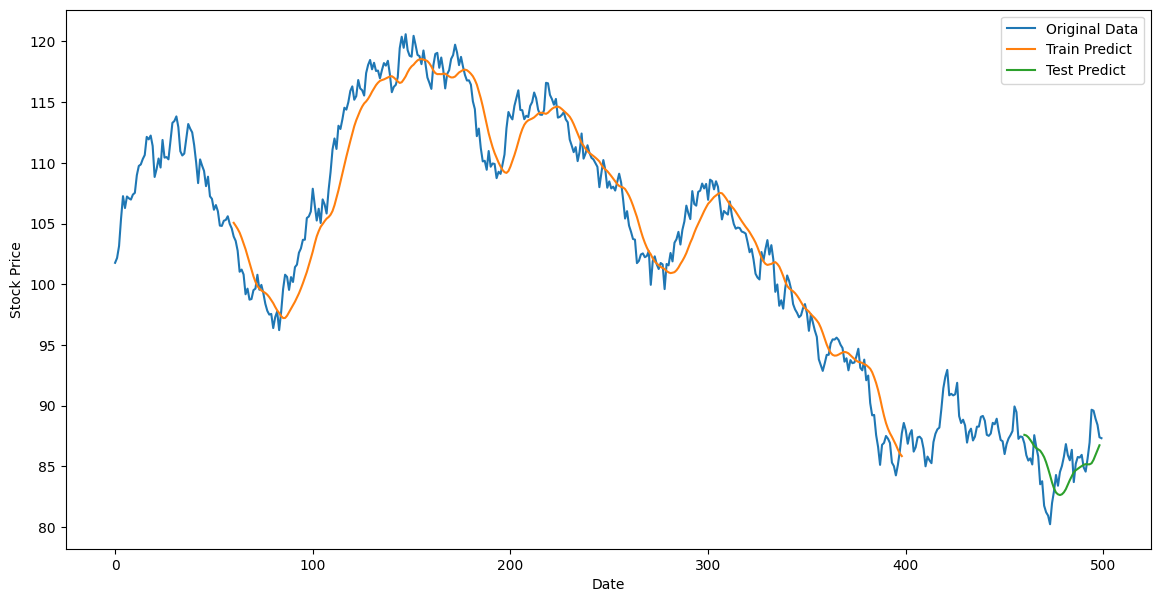

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(data, label='Original Data')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()